# Notebook 3: Deep Learning Model for Video Classification using LSTM and TensorFlow

## Introduction

The field of deep learning has seen significant advancements in recent years, particularly in the area of video classification. Video classification plays a crucial role in various applications such as surveillance, action recognition, and human behavior analysis. In this notebook, we explore the implementation of a deep learning model using LSTM (Long Short-Term Memory) and TensorFlow for video classification. We leverage the power of LSTM to capture temporal dependencies in video sequences and TensorFlow, a popular deep learning framework, for efficient model development and training.



##1. System Setup


In [1]:
import sys
import tensorflow as tf

print(f"Python version: {sys.version}")
print(f"Tensorflow version: {tf.__version__}")

Python version: 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
Tensorflow version: 2.13.0


In [2]:
import os
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix
import random
import glob
import numpy as np
from tensorflow import keras
import seaborn as sns
import matplotlib.pyplot as plt

##2. Mounting Google Drive

In [3]:
# mouting google drive
from google.colab import drive
drive.mount('/content/drive')
# testing
%cd /content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset
%ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset
bad_back_round/  bad_head/         bad_shallow/  good/
bad_back_warp/   bad_inner_thigh/  bad_toe/      model.png


##3. Data preparation

### Define paths to the dataset

In [4]:
# Define Path to the Dataset folder
BASE_PATH = '/content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset'
VIDEOS_PATH = os.path.join(BASE_PATH,'**','*.npy')
print(VIDEOS_PATH)


# Define LSTM sequence length and batch_size
SEQUENCE_LENGTH = 40
BATCH_SIZE = 16

/content/drive/Othercomputers/PFE/PFE2023/data/Video_Dataset/**/*.npy


One Hot Encoding

In [5]:
LABELS = ['good', 'bad_inner_thigh', 'bad_toe', 'bad_shallow', 'bad_back_round', 'bad_back_warp', 'bad_head']
encoder = LabelBinarizer()
encoder.fit(LABELS)
print(encoder.classes_)
print(encoder.transform(LABELS))

['bad_back_round' 'bad_back_warp' 'bad_head' 'bad_inner_thigh'
 'bad_shallow' 'bad_toe' 'good']
[[0 0 0 0 0 0 1]
 [0 0 0 1 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 1 0 0]
 [1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]]


##4. Splitting the data ( train/test/validation)

In [6]:
TRAIN_PERCENTAGE = 0.7
VAL_PERCENTAGE = 0.2

data_paths_by_class = {}

# Collect video paths for each class
for label in LABELS:
    folder_path = os.path.join(BASE_PATH, label)
    videos = glob.glob(os.path.join(folder_path, '*.npy'))
    data_paths_by_class[label] = videos

# Shuffle and divide videos by class
train_list = []
val_list = []
test_list = []

for class_name, video_paths in data_paths_by_class.items():
    random.shuffle(video_paths)
    total_videos = len(video_paths)
    train_size = int(TRAIN_PERCENTAGE * total_videos)
    val_size = int(VAL_PERCENTAGE * total_videos)

    train_list.extend(video_paths[:train_size])
    val_list.extend(video_paths[train_size:train_size + val_size])
    test_list.extend(video_paths[train_size + val_size:])

# Shuffle the overall lists
random.shuffle(train_list)
random.shuffle(val_list)
random.shuffle(test_list)

# Print the number of videos in each set
print(f'Training: {len(train_list)} videos')
print(f'Validation: {len(val_list)} videos')
print(f'Test: {len(test_list)} videos')


Training: 2545 videos
Validation: 724 videos
Test: 371 videos


In [7]:
def make_generator(file_list):
  def generator():
    #np.random.shuffle(file_list)
    for path in file_list:
      label = os.path.basename(os.path.dirname(path))
      features = np.load(path)
      padded_sequence = np.zeros((SEQUENCE_LENGTH,1792)) # Efficientnet feature extractor
      padded_sequence[0:len(features)] = np.array(features)
      transform_label = encoder.transform([label])
      yield padded_sequence, transform_label[0]
  return generator

In [8]:
# Train dataset
train_dataset = tf.data.Dataset.from_generator(make_generator(train_list),
                                               output_types=(tf.float32, tf.int32),
                                               output_shapes=((SEQUENCE_LENGTH, 1792), (len(LABELS))))
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)

# Validation dataset
valid_dataset = tf.data.Dataset.from_generator(make_generator(val_list),
                                               output_types=(tf.float32, tf.int32),
                                               output_shapes=((SEQUENCE_LENGTH, 1792), (len(LABELS))))
valid_dataset = valid_dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)

# Test dataset
test_dataset = tf.data.Dataset.from_generator(make_generator(test_list),
                                              output_types=(tf.float32, tf.int32),
                                              output_shapes=((SEQUENCE_LENGTH, 1792), (len(LABELS))))
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)

# Print Train, Valid, and Test datasets
print("Train dataset:")
print(train_dataset)
print("\nValid dataset:")
print(valid_dataset)
print("\nTest dataset:")
print(test_dataset)


Train dataset:
<_PrefetchDataset element_spec=(TensorSpec(shape=(16, 40, 1792), dtype=tf.float32, name=None), TensorSpec(shape=(16, 7), dtype=tf.int32, name=None))>

Valid dataset:
<_PrefetchDataset element_spec=(TensorSpec(shape=(16, 40, 1792), dtype=tf.float32, name=None), TensorSpec(shape=(16, 7), dtype=tf.int32, name=None))>

Test dataset:
<_PrefetchDataset element_spec=(TensorSpec(shape=(16, 40, 1792), dtype=tf.float32, name=None), TensorSpec(shape=(16, 7), dtype=tf.int32, name=None))>


##5. Preparing the LSTM model



Define LSTM Model with following layers:


*   Layer 1 = Masking Layer ( see keras [Doc](https://keras.io/api/layers/core_layers/masking/) )
*   Layer 2 = Defind what **1** cell of LSTM looks like [LSTM layer](https://keras.io/api/layers/recurrent_layers/lstm/). The total number of cells is defined as SEQUENCE_LENGTH above
*   Layer 3 = FNC (fully-connected layer) relu activation ( see [Dense layer](https://keras.io/api/layers/core_layers/dense/) )
*   Layer 4 = Drouput layer
*   Layer 5 = final decision FNC layer with softmax activation -- output has length of classes



In [9]:
model = tf.keras.Sequential([
                            tf.keras.layers.Masking(mask_value=0.),
                            tf.keras.layers.LSTM(600,dropout=0.5,recurrent_dropout=0.5), # 512 units (hidden-layer)
                            tf.keras.layers.Dense(512,activation='relu'),
                            tf.keras.layers.Dropout(0.5),
                            tf.keras.layers.Dense(256,activation='relu'),
                            tf.keras.layers.Dropout(0.5),
                            tf.keras.layers.Dense(128,activation='relu'),
                            tf.keras.layers.Dropout(0.5),
                            tf.keras.layers.Dense(7,activation='softmax')
])

In [10]:
op = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
             optimizer=op,
             metrics=[tf.keras.metrics.CategoricalAccuracy()])

##6. Training the model

In [11]:
ROOT_PATH = "/content/drive/Othercomputers/PFE/PFE2023/Training"
LOG_DIR = os.path.join(ROOT_PATH,'logs')
TRAIN_MODELS_DIR = os.path.join(ROOT_PATH,'models')
CHECKPOINTS_DIR = os.path.join(ROOT_PATH,'checkpoints')
# Create new dir if not exists
if not os.path.isdir(LOG_DIR):
  !mkdir {LOG_DIR}
if not os.path.isdir(TRAIN_MODELS_DIR):
  !mkdir {TRAIN_MODELS_DIR}
if not os.path.isdir(CHECKPOINTS_DIR):
  !mkdir {CHECKPOINTS_DIR}

In [12]:
my_callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(verbose=1),
    tf.keras.callbacks.ModelCheckpoint(CHECKPOINTS_DIR, monitor='val_loss', save_best_only=True, mode='max'),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7),  # Stop after 7 iterations without change
]

In [13]:
history= model.fit(train_dataset, epochs=50, validation_data=valid_dataset, callbacks=my_callbacks, verbose=1)

Epoch 1/50
159/159 [==============================] - 839s 5s/step - loss: 1.7671 - categorical_accuracy: 0.2366 - val_loss: 1.4529 - val_categorical_accuracy: 0.3097 - lr: 0.0010
Epoch 2/50
159/159 [==============================] - 185s 1s/step - loss: 1.4896 - categorical_accuracy: 0.3003 - val_loss: 1.3918 - val_categorical_accuracy: 0.3375 - lr: 0.0010
Epoch 3/50
159/159 [==============================] - 185s 1s/step - loss: 1.4493 - categorical_accuracy: 0.3180 - val_loss: 1.3710 - val_categorical_accuracy: 0.3917 - lr: 0.0010
Epoch 4/50
159/159 [==============================] - 192s 1s/step - loss: 1.3921 - categorical_accuracy: 0.3494 - val_loss: 1.3245 - val_categorical_accuracy: 0.3833 - lr: 0.0010
Epoch 5/50
159/159 [==============================] - 184s 1s/step - loss: 1.3385 - categorical_accuracy: 0.3943 - val_loss: 1.2699 - val_categorical_accuracy: 0.4639 - lr: 0.0010
Epoch 6/50
159/159 [==============================] - 196s 1s/step - loss: 1.2631 - categorical_accu

In [ ]:
IMG_SIZE=380

In [ ]:
efficientnet_b4 = tf.keras.applications.EfficientNetB4(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                                       include_top=False,
                                                       weights='imagenet')

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 40, 1792)          0         
                                                                 
 lstm (LSTM)                 (None, 600)               5743200   
                                                                 
 dense (Dense)               (None, 512)               307712    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               3

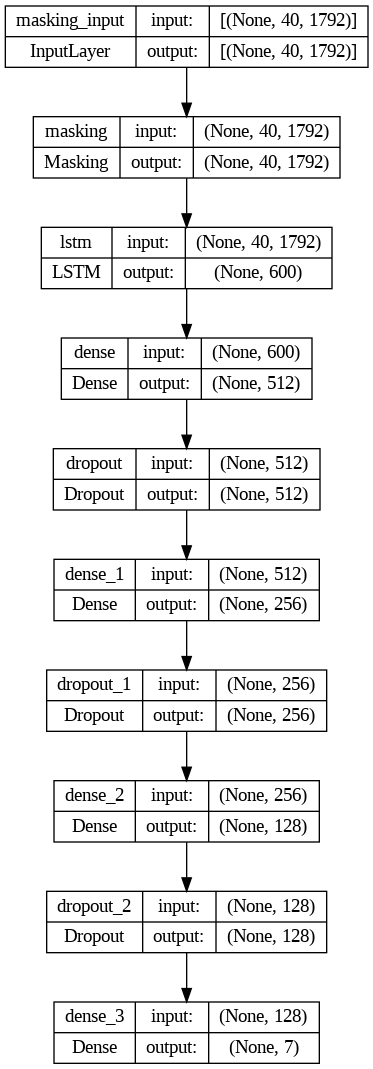

In [15]:
# Plot the model
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [16]:
from datetime import datetime

# Specify the base path and file name for saving the model
base_path = '/content/drive/Othercomputers/PFE/PFE2023/Training/models/'
model_name = 'LSTM_model'

# Get the current date and time
current_datetime = datetime.now().strftime("%Y_%m_%d__%H_%M")

# Define the model file name with date, loss, and accuracy
model_file_name = f"{model_name}___Date_Time_{current_datetime}___Loss_{history.history['loss'][-1]}___Accuracy_{history.history['categorical_accuracy'][-1]}.h5"

# Save the model with the updated file name
model.save(base_path + model_file_name)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [23]:
model.save('base_path + model_file_name.keras')

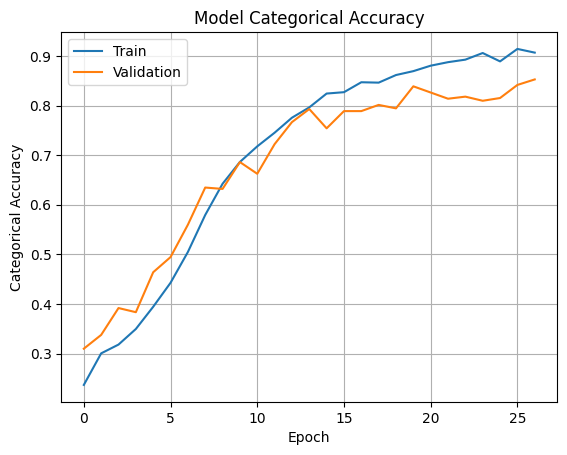

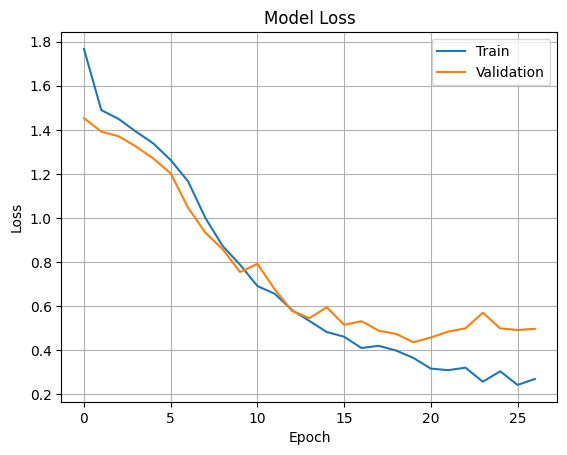

In [17]:
import matplotlib.pyplot as plt

# Plot the accuracy curve
plt.plot(history.history['categorical_accuracy'], label='Train')
plt.plot(history.history['val_categorical_accuracy'], label='Validation')
plt.title('Model Categorical Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Categorical Accuracy')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# Plot the loss curve
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


### Defining the confusion matrix plotting function

In [18]:
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, labels):
    figure = plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    threshold = cm.max() / 2.
    # Loop through each square
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if cm[i, j] > threshold:
                color = "white"
            else:
                color = "black"
            plt.text(j, i, cm[i, j], horizontalalignment='center', color=color)

    # These should be outside the loop
    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')
    plt.tight_layout()


##7. Evaluation on test set

In [19]:
model_file_name= 'LSTM_model___Date_Time_2023_09_07__22_37___Loss_0.22159309685230255___Accuracy_0.919025182723999.h5'

Evaluate on test Data
23/23 [==============================] - 84s 4s/step - loss: 0.3405 - categorical_accuracy: 0.8995
Test Loss, Test Accuracy: [0.3405146896839142, 0.8994565010070801]
23/23 [==============================] - 11s 457ms/step


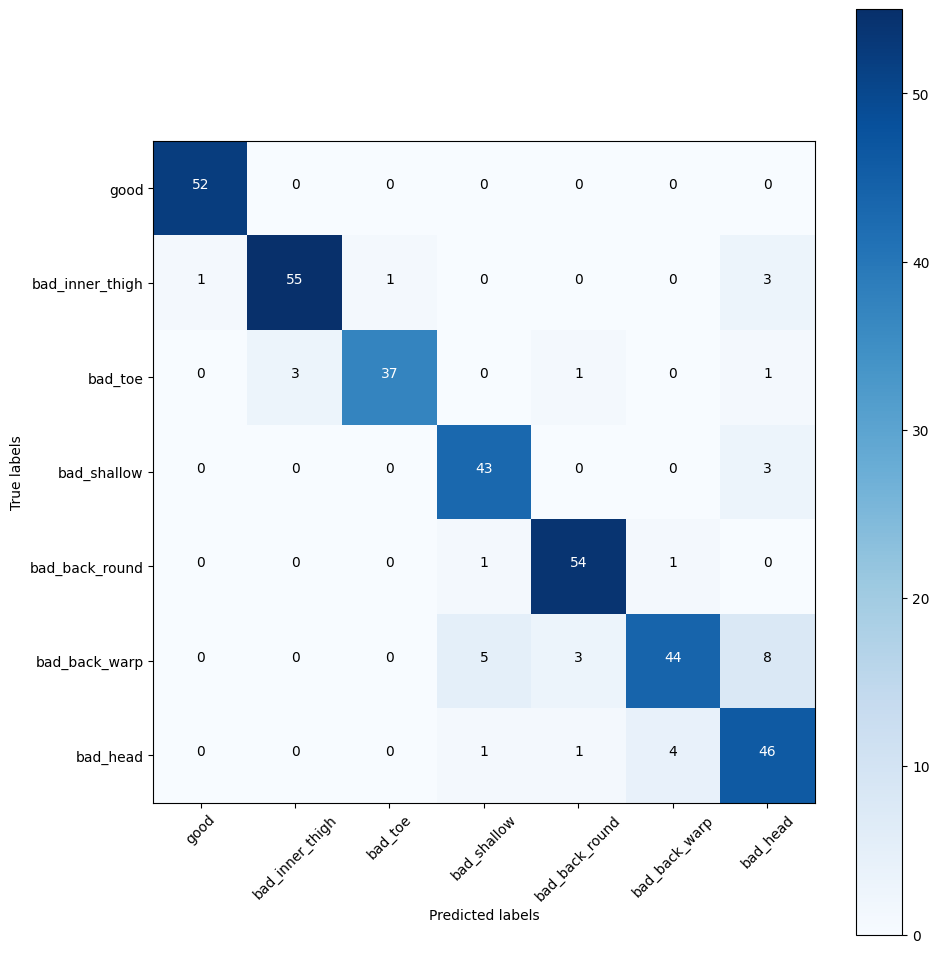

In [20]:
print('Evaluate on test Data')
model = tf.keras.models.load_model(base_path+model_file_name)

test_result = model.evaluate(test_dataset, verbose=1)
print(f'Test Loss, Test Accuracy: {test_result}')


prediction = model.predict(test_dataset)
# Get the max value and flatten
predicted_categories = tf.argmax(prediction, axis=1)

# Need to get the ground truth from dataset
ground_truth_label = []
true_categories = tf.concat([y for _, y in test_dataset],axis=0)

for i in true_categories:
  value = tf.argmax(i,axis=0)
  ground_truth_label.append(value)

confusion_matrix = tf.math.confusion_matrix(tf.convert_to_tensor(ground_truth_label,dtype=tf.int64),predicted_categories,num_classes=7)
plot_confusion_matrix(np.array(confusion_matrix),LABELS)


##8. Evaluation on validation set

Evaluate on validation Data
45/45 [==============================] - 14s 302ms/step - loss: 0.2366 - categorical_accuracy: 0.9181
validation Loss, validation Accuracy: [0.2366175800561905, 0.918055534362793]
45/45 [==============================] - 14s 303ms/step


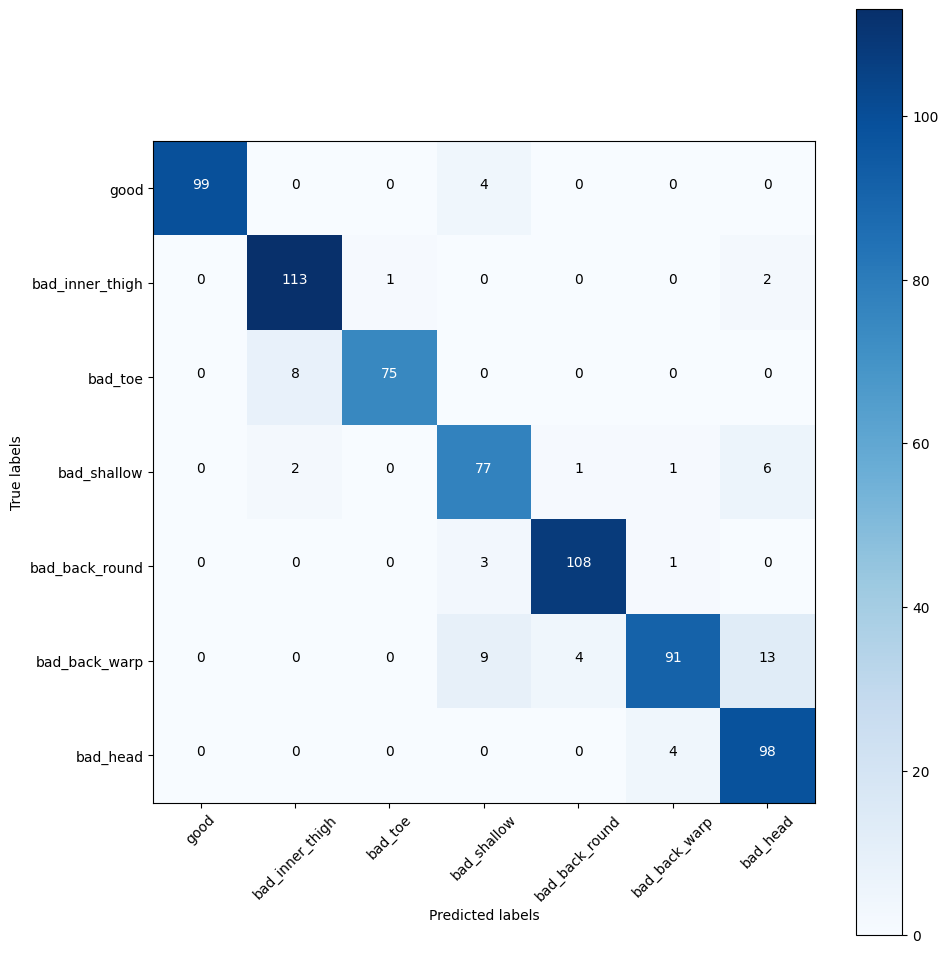

In [21]:
print('Evaluate on validation Data')
model = tf.keras.models.load_model(base_path+model_file_name)

validation_result = model.evaluate(valid_dataset, verbose=1)
print(f'validation Loss, validation Accuracy: {validation_result}')


prediction = model.predict(valid_dataset)
# Get the max value and flatten
predicted_categories = tf.argmax(prediction, axis=1)

# Need to get the ground truth from dataset
ground_truth_label = []
true_categories = tf.concat([y for _, y in valid_dataset],axis=0)

for i in true_categories:
  value = tf.argmax(i,axis=0)
  ground_truth_label.append(value)

confusion_matrix = tf.math.confusion_matrix(tf.convert_to_tensor(ground_truth_label,dtype=tf.int64),predicted_categories,num_classes=7)
plot_confusion_matrix(np.array(confusion_matrix),LABELS)

In [24]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score

# Calculate accuracy
accuracy = accuracy_score(ground_truth_label, predicted_categories)

# Calculate precision, recall, and F1 score for each class
precision = precision_score(ground_truth_label, predicted_categories, average='macro')
recall = recall_score(ground_truth_label, predicted_categories, average='macro')
f1 = f1_score(ground_truth_label, predicted_categories, average='macro')

# Calculate macro-averaged precision, recall, and F1 score
macro_precision = precision_score(ground_truth_label, predicted_categories, average='macro')
macro_recall = recall_score(ground_truth_label, predicted_categories, average='macro')
macro_f1 = f1_score(ground_truth_label, predicted_categories, average='macro')

# Calculate micro-averaged precision, recall, and F1 score
micro_precision = precision_score(ground_truth_label, predicted_categories, average='micro')
micro_recall = recall_score(ground_truth_label, predicted_categories, average='micro')
micro_f1 = f1_score(ground_truth_label, predicted_categories, average='micro')

# Generate a classification report containing precision, recall, F1 score, and support for each class
classification_metrics = classification_report(ground_truth_label, predicted_categories, target_names=LABELS)

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('Macro-Averaged Precision:', macro_precision)
print('Macro-Averaged Recall:', macro_recall)
print('Macro-Averaged F1 Score:', macro_f1)
print('Micro-Averaged Precision:', micro_precision)
print('Micro-Averaged Recall:', micro_recall)
print('Micro-Averaged F1 Score:', micro_f1)
print('Classification Report:')
print(classification_metrics)


Accuracy: 0.9180555555555555
Precision: 0.9215606050790476
Recall: 0.9181175306375496
F1 Score: 0.9174430877296036
Macro-Averaged Precision: 0.9215606050790476
Macro-Averaged Recall: 0.9181175306375496
Macro-Averaged F1 Score: 0.9174430877296036
Micro-Averaged Precision: 0.9180555555555555
Micro-Averaged Recall: 0.9180555555555555
Micro-Averaged F1 Score: 0.9180555555555555
Classification Report:
                 precision    recall  f1-score   support

           good       1.00      0.96      0.98       103
bad_inner_thigh       0.92      0.97      0.95       116
        bad_toe       0.99      0.90      0.94        83
    bad_shallow       0.83      0.89      0.86        87
 bad_back_round       0.96      0.96      0.96       112
  bad_back_warp       0.94      0.78      0.85       117
       bad_head       0.82      0.96      0.89       102

       accuracy                           0.92       720
      macro avg       0.92      0.92      0.92       720
   weighted avg       0.92  

##9. Evaluation on another dataset




[0.3405146896839142, 0.8994565010070801]
tf.Tensor(
[6 5 3 3 2 5 4 0 2 2 4 4 1 0 4 4 5 1 2 0 3 1 4 6 2 6 5 6 2 2 1 3 0 4 4 2 3
 5 4 6 6 3 5 3 3 0 0 3 5 0 4 3 5 3 0 6 6 6 2 6 1 1 5 0 0 5 4 1 1 4 5 3 6 4
 4 5 6 1 3 6 0 0 2 4 3 4 4 5 4 6 5 5 2 1 6 1 3 4 3 6 4 6 5 5 0 1 1 1 1 1 0
 2 2 3 3 3 2 5 0 3 3 3 6 6 4 4 4 1 0 2 6 1 1 3 6 4 1 6 0 5 3 6 0 1 1 4 4 0
 2 3 5 0 3 0 6 6 1 3 6 5 2 5 3 4 5 4 0 6 2 0 5 5 5 1 4 6 0 4 5 1 4 2 5 0 6
 0 5 5 0 6 5 5 6 5 4 4 1 1 0 6 1 0 4 4 3 1 3 4 3 5 1 2 0 4 0 6 5 0 3 0 0 0
 2 3 0 1 5 4 6 0 0 0 6 4 6 2 5 3 5 6 2 4 2 4 3 2 3 6 2 1 5 6 0 5 6 4 4 1 3
 1 5 6 1 2 2 0 2 0 0 5 1 6 1 1 1 1 0 0 2 3 4 0 6 2 1 4 5 4 2 6 5 6 4 0 6 3
 6 2 6 3 1 6 4 3 3 2 0 6 2 6 1 4 6 2 6 0 1 1 0 4 1 1 3 3 3 1 3 0 2 4 4 6 6
 4 5 5 1 3 6 4 1 4 6 1 6 4 1 1 3 6 0 6 1 4 1 1 6 0 5 4 5 3 2 4 5 1 1 3], shape=(368,), dtype=int64)
tf.Tensor(
[[52  0  0  0  0  0  0]
 [ 1 55  1  0  0  0  3]
 [ 0  3 37  0  1  0  1]
 [ 0  0  0 43  0  0  3]
 [ 0  0  0  1 54  1  0]
 [ 0  0  0  5  3 44  8]
 [ 0  0  0  1  1  

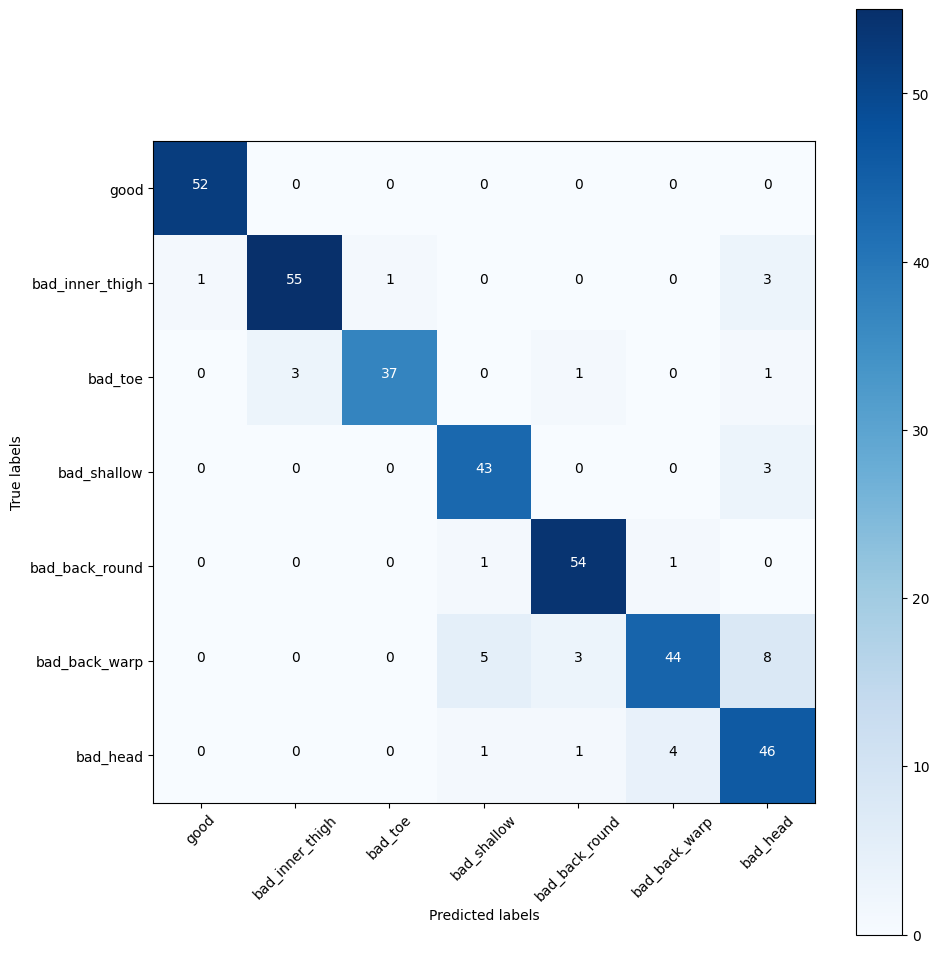

In [25]:
test_result = model.evaluate(test_dataset,verbose=0)
print(test_result)
prediction = model.predict(test_dataset,verbose=0)


# Get the max value and flatten
predicted_categories = tf.argmax(prediction, axis=1)
print(predicted_categories)

# Need to get the ground truth from dataset
ground_truth_label = []
true_categories = tf.concat([y for _, y in test_dataset],axis=0)

for i in true_categories:
  value = tf.argmax(i,axis=0)
  ground_truth_label.append(value)


confusion_matrix = tf.math.confusion_matrix(tf.convert_to_tensor(ground_truth_label,dtype=tf.int64),predicted_categories,num_classes=7)
print(confusion_matrix)

plot_confusion_matrix(np.array(confusion_matrix),LABELS)

# with open('/content/drive/MyDrive/USquat_Training/tricky_text_file.txt','w') as f:
for i in range(len(prediction)):
  expected = test_list[i].split('/')[8]
  print(test_list[i])
  max = tf.argmax(np.array(predicted_categories))
  print(f'extected: {expected} -- prediction: {prediction[i]}')
  print('\n----------------------------------------')


In [29]:
# Save the model in H5 format
model.save(base_path+model_file_name)

## Conclusion

In this notebook, we have demonstrated the implementation of a deep learning model for video classification using LSTM and TensorFlow. We began by setting up the system environment, including the installation of necessary packages and mounting Google Drive for data access. We then defined the necessary paths and variables, created labels for our classes, and split the data into training and test sets. The LSTM model architecture was designed, incorporating masking, LSTM layers, fully-connected layers, and dropout regularization. The model was trained using the training dataset, and evaluation was performed on the test dataset. Confusion matrices were generated to assess the model's performance in classifying the videos accurately. The results highlight the effectiveness of

the LSTM-based model in video classification tasks. Further improvements and optimizations can be explored to enhance the model's performance and applicability in real-world scenarios.